## Non-variational fixed-depth Hamiltonian simulation

Here we time the FDHS example with non-variational KAK decomposition.

In [1]:
from functools import partial
from itertools import combinations, product
import numpy as np
import time
np.random.seed(2415)
from scipy.linalg import expm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from tqdm.notebook import tqdm

import jax
jax.config.update("jax_enable_x64", True)

import pennylane as qml
from pennylane import X, Y, Z, I
from pennylane.pauli import PauliWord
from pennylane.devices.default_qubit import stopping_condition as sc_def

from kak_tools import (
    map_simple_to_irrep,
    map_irrep_to_matrices,
    identify_algebra,
    split_pauli_algebra,
    bdi,
    lie_closure_pauli_words,
    recursive_bdi,
    map_recursive_decomp_to_reducible,
    map_matrix_to_reducible,
)

In [2]:
# Helper functions
def make_so_2n_hamiltonian(n, coefficients="random"):
    couplings = [X(w) @ X(w+1) for w in range(n-1)] + [Y(w) @ Y(w+1) for w in range(n-1)]
    Zs = [Z(w) for w in range(n)]
    generators = couplings + Zs
    if coefficients == "random":
        alphas = np.random.normal(0.6, 1., size=n-1)
        betas = np.random.normal(0.3, 1.2, size=n-1)
        gammas = np.random.normal(0., 0.3, size=n)
    elif coefficients == "random TF":
        alphas = np.ones(n-1)
        betas = np.ones(n-1)
        gammas = np.random.normal(0., 0.3, size=n)
    elif coefficients == "uniform":
        alphas = np.ones(n-1)
        betas = np.ones(n-1)
        gammas = np.ones(n)
    
    coeffs = np.concatenate([alphas, betas, gammas])
    coeffs /= np.linalg.norm(coeffs) # Normalization
    H = qml.dot(coeffs, generators)
    generators = [next(iter(op.pauli_rep)) for op in generators]
    return H, generators, coeffs

def make_so_2n(n):
    algebra = [qml.prod(*([P1(w)] + [Z(i) for i in range(w+1, v)] + [P2(v)])) for w, v in combinations(range(n), r=2) for P1, P2 in product([X, Y], repeat=2)]
    algebra += [Z(w) for w in range(n)]
    return [next(iter(op.pauli_rep)) for op in algebra]

def make_so_2n_mapping(n):
    mapping = {(i, i+n): PauliWord({i: "Z"}) for i in range(n)}
    mapping |= {(i, i+n+1): PauliWord({i: "X", i+1: "X"}) for i in range(n-1)}
    mapping |= {(i, i+n-1): PauliWord({i-1: "Y", i: "Y"}) for i in range(1, n)}
    return mapping

In [3]:
# Config

coefficients = "random"
use_predefined_algebra = True
use_predefined_horizontal_mapping = True
ns = list(np.arange(2, 6, dtype=int) ** 2)

In [7]:
times_mapping = []
times_decomposing = []
times_mapping_back = []
times_rest = []
times_total = []

for n in ns:
    n = int(n)
    H, generators, coeffs = make_so_2n_hamiltonian(n, coefficients)

    
    start = time.process_time()

    if use_predefined_algebra:
        algebra = make_so_2n(n)
    else:
        algebra = lie_closure_pauli_words(generators, verbose=False)
    start = time.process_time()
    n_so = 2 * n
    so_dim = (n_so**2-n_so) // 2
    assert len(algebra) == so_dim, f"{len(algebra)}, {so_dim}"

    start_mapping = time.process_time()

    if use_predefined_horizontal_mapping:
        horizontal_ops = make_so_2n_mapping(n)
    else:
        horizontal_ops = generators
    mapping, signs = map_simple_to_irrep(algebra, horizontal_ops=horizontal_ops, n=n_so, invol_type="BDI", invol_kwargs={"p": n_so//2, "q": (n_so+1)//2})
    matrix_map = map_irrep_to_matrices(mapping, signs, n=n_so, invol_type="BDI")
    end_mapping = time.process_time()
    
    terms_irrep = np.stack([matrix_map[gen] for gen in generators])
    H_irrep = np.tensordot(coeffs, terms_irrep, axes=[[0], [0]])

    epsilon = 0.01
    U = expm(epsilon * H_irrep)

    start_decomposing = time.process_time()
    recursive_decomp = recursive_bdi(U, n_so)
    end_decomposing = time.process_time()

    start_mapping_back = time.process_time()
    pauli_decomp = map_recursive_decomp_to_reducible(recursive_decomp, mapping, signs, invol_type="BDI", time=epsilon, tol=None, assertions=False)
    end_mapping_back = time.process_time()
    paulirot_decomp = [(coeff, qml.pauli.pauli_word_to_string(pw), pw.wires, _type) for pw, coeff, _type in pauli_decomp]

    end = time.process_time()
    
    times_mapping.append(end_mapping - start_mapping)
    times_decomposing.append(end_decomposing - start_decomposing)
    times_mapping_back.append(end_mapping_back - start_mapping_back)
    times_total.append(end - start)
    times_rest.append(times_total[-1] - times_mapping[-1] - times_mapping_back[-1] - times_decomposing[-1])
    
    print(f"Decomposed exp(iHt) on {n} qubits into {len(paulirot_decomp)} Pauli rotations (DLA dimension: {so_dim}, Duration: {times_total[-1]:.3}s).")

Decomposed exp(iHt) on 4 qubits into 28 Pauli rotations (DLA dimension: 28, Duration: 0.00777s).
Decomposed exp(iHt) on 9 qubits into 153 Pauli rotations (DLA dimension: 153, Duration: 0.0426s).
Decomposed exp(iHt) on 16 qubits into 496 Pauli rotations (DLA dimension: 496, Duration: 0.0994s).
Decomposed exp(iHt) on 25 qubits into 1222 Pauli rotations (DLA dimension: 1225, Duration: 0.237s).


/tmp/ipykernel_3507674/3876260320.py:7: RuntimeWarning: invalid value encountered in power
  f = lambda x, a, b: (b * x)**a


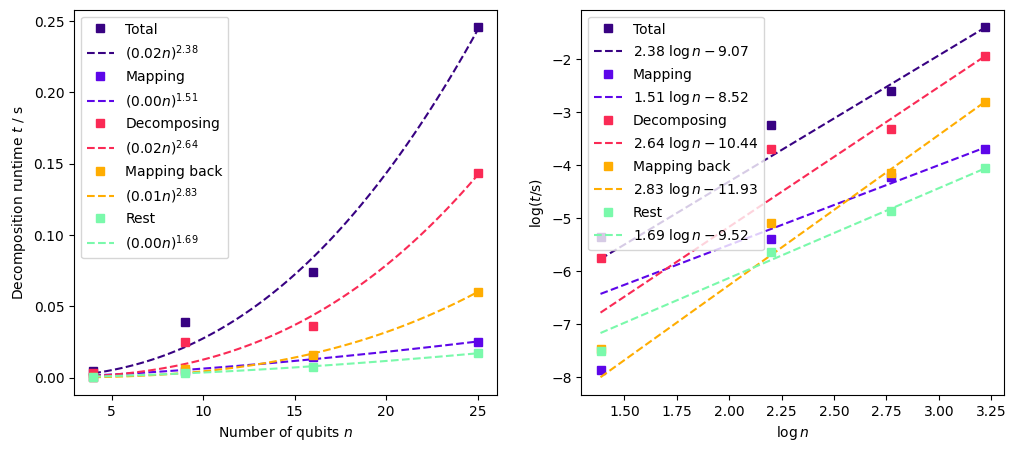

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
all_times = [times_total, times_mapping, times_decomposing, times_mapping_back, times_rest]
colors = ["xkcd:indigo", "xkcd:blue violet", "xkcd:red pink", "xkcd:orange yellow", "xkcd:seafoam green"]
labels = ["Total", "Mapping", "Decomposing", "Mapping back", "Rest"]
for times, label, c in zip(all_times, labels, colors):
    # f = lambda x, a, b: a * x + b
    f = lambda x, a, b: (b * x)**a
    # popt, pcov = curve_fit(f, np.log(ns)[3:], np.log(times)[3:])
    popt, pcov = curve_fit(f, ns, times)
    cont_ns = np.linspace(ns[0], ns[-1], 100)
    
    ax = axs[0]
    ax.plot(ns, times, marker="s", c=c, label=label, ls="")
    # ax.plot(cont_ns, np.exp(f(np.log(cont_ns), *popt)), ls = "--", c="xkcd:red pink", label=f"${popt[1]:.1f}n^{{{popt[0]:.2f}}}$")
    ax.plot(cont_ns, f(cont_ns, *popt), ls = "--", c=c, label=f"$({popt[1]:.2f}n)^{{{popt[0]:.2f}}}$")
    ax.set_xlabel("Number of qubits $n$")
    ax.set_ylabel("Decomposition runtime $t$ / s")
    ax.legend()
    ax = axs[1]
    ax.plot(np.log(ns), np.log(times), marker="s", c=c, label=label, ls="")
    # ax.plot(np.log(ns), f(np.log(ns), *popt), ls = "--", c="xkcd:red pink", label=f"${popt[0]:.2f}\ \log n {popt[1]:.1f}$")
    ax.plot(np.log(cont_ns), np.log(f(cont_ns, *popt)), ls = "--", c=c, label=f"${popt[0]:.2f}\ \log n {popt[0] * np.log(popt[1]):.2f}$")
    ax.set_xlabel("$\log n$")
    ax.set_ylabel("$\log (t/\\text{s})$")
    ax.legend()

In [6]:
%prun -s cumulative map_simple_to_irrep(algebra, horizontal_ops=make_so_2n_mapping(n), n=n_so, invol_type="BDI", invol_kwargs={"p": n_so//2, "q": (n_so+1)//2})

         85342 function calls in 0.036 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.036    0.036 {built-in method builtins.exec}
        1    0.000    0.000    0.036    0.036 <string>:1(<module>)
        1    0.000    0.000    0.035    0.035 map_to_irrep.py:342(map_simple_to_irrep)
     2376    0.001    0.000    0.020    0.000 pauli_arithmetic.py:333(_commutator)
        1    0.002    0.002    0.017    0.017 map_to_irrep.py:261(map_coms)
        1    0.001    0.001    0.011    0.011 map_to_irrep.py:326(make_signs)
     2376    0.006    0.000    0.011    0.000 pauli_arithmetic.py:223(_matmul)
     5004    0.005    0.000    0.009    0.000 pauli_arithmetic.py:325(commutes_with)
     2588    0.001    0.000    0.004    0.000 {built-in method builtins.sum}
        1    0.000    0.000    0.004    0.004 pauli_dlas.py:16(anticom_graph_pauli)
     2449    0.003    0.000    0.003    0.000 pauli_ar